# Estonia Survival Prediction

In this notebook I have performed EDA using plotly and survival prediction using ensemble model.

### Survival Prediction:

There is a class imbalance problem in data, I have used ensembled stack of RandomForestClassifier, SVC, GradientBoostingClassifier and LogisticRegressionClassifier with class weights to solve the problem.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import math

plt.style.use('seaborn')
seed = 6467
np.random.seed(seed)

%matplotlib inline

In [2]:
df = pd.read_csv('../input/passenger-list-for-the-estonia-ferry-disaster/estonia-passenger-list.csv')

In [3]:
df.head()

,PassengerId,Country,Firstname,Lastname,Sex,Age,Category,Survived
0,1,Sweden,ARVID KALLE,AADLI,M,62,P,0
1,2,Estonia,LEA,AALISTE,F,22,C,0
2,3,Estonia,AIRI,AAVASTE,F,21,C,0
3,4,Sweden,JURI,AAVIK,M,53,C,0
4,5,Sweden,BRITTA ELISABET,AHLSTROM,F,55,P,0


PassengerId, Firstname and Lastname are not going to help in prediction, let's drop them.

In [4]:
df.drop(columns = ['PassengerId','Firstname','Lastname'], inplace=True)
len(df)

989

## EDA

Let's check for null values and unique values count for each feature.

In [5]:
df.isnull().sum()

Country     0
Sex         0
Age         0
Category    0
Survived    0
dtype: int64

In [6]:
df.nunique()

Country     16
Sex          2
Age         78
Category     2
Survived     2
dtype: int64

Looks like except Age other columns are categorical.

Let's plot the data.

In [7]:
fig = px.histogram(df, x="Age", color="Sex", marginal="box",
                   hover_data=df.columns, title="Age Distribution accross gender")
fig.show()

We can see from above distribution plot that average age range for female is 32-59 and for male is 29-58. 

Let's plot the bar plots for categorical features values against their counts.

In [8]:
fig = go.Figure(data=[
    go.Bar(name='Survived', y=df[df['Survived']==1]['Country'].value_counts().values, x=df[df['Survived']==1]['Country'].value_counts().index),
    go.Bar(name='Not Survived', y=df[df['Survived']==0]['Country'].value_counts().values, x=df[df['Survived']==0]['Country'].value_counts().index)
])
# Change the bar mode
fig.update_layout(barmode='group', title_text = 'Survival count accross countries')
fig.show()

We can see that passengers from country Estonia have high survival count.

In [9]:
fig = px.sunburst(df, path=['Category', 'Survived'], title='Survival count accross category')
fig.show()

Looks like Crew members have high survival_count/total value than Passengers.

In [10]:
fig = go.Figure(data=[
    go.Bar(name='Survived', y=df[df['Survived']==1]['Sex'].value_counts().values, x=df[df['Survived']==1]['Sex'].value_counts().index),
    go.Bar(name='Not Survived', y=df[df['Survived']==0]['Sex'].value_counts().values, x=df[df['Survived']==0]['Sex'].value_counts().index)
])
# Change the bar mode
fig.update_layout(barmode='group', title_text='Survival count accross gender')
fig.show()

Survival count for male is clearly higher than that of females.

In [11]:
fig = px.pie(df, names='Survived', title='Survival class distribution')
fig.show()

We can clearly see the class imbalance.

Let's prepare data for prediction by LabelEncoding the values.

In [12]:
features = ['Country','Sex','Category']
df[features] = df[features].apply(preprocessing.LabelEncoder().fit_transform)

In [13]:
df.head()

,Country,Sex,Age,Category,Survived
0,15,1,62,1,0
1,3,0,22,0,0
2,3,0,21,0,0
3,15,1,53,0,0
4,15,0,55,1,0


In [14]:
corr = df.corr()
fig = px.imshow(corr)
fig.show()

## Prediction

Let's start with dividing data into train and test sets.

In [15]:
X = df.drop(columns=['Survived'])
y = df['Survived']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=seed)

Let's define the models that we are going to use for prediction. On top of base classifiers, I am using VotingClassifier to get final prediction.

In [16]:
rf_model = RandomForestClassifier(n_estimators=10, class_weight={0:1, 1:5})
gb_model = GradientBoostingClassifier(n_estimators=10)
svm_model = SVC(class_weight={0:1, 1:6},probability=True)
logreg_model = LogisticRegression(class_weight={0:1, 1:5})
ensemble = VotingClassifier([('rf',rf_model),('gb',gb_model),('svc',svm_model),('lg',logreg_model)], voting='soft')

models = {'Random Forest':rf_model, 'Gradient Boosting' :gb_model, 'SVC' :svm_model, 'Logistic Regression': logreg_model, 'Ensemble': ensemble}
names = ['Random Forest','Gradient Boosting','SVC','Logistic Regression','Ensemble']


In [17]:
n_repeats = 10
rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=n_repeats, random_state=seed)

In [18]:
i=0
roc_auc_scores = np.zeros(5)
for train_index, val_index in rskf.split(train_x, train_y):
    
    x_train, x_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
    models[names[i]].fit(x_train, y_train)
    y_pred = models[names[i]].predict_proba(x_val)   
    y_proba = [p[1] for p in y_pred]
    roc_auc_scores[i] += roc_auc_score(y_val, y_proba)
  
    i += 1
    
    if i == 5:
        i=0

roc_auc_scores = roc_auc_scores/(n_repeats-2)
for i in range(len(names)):
    print(f"Validation ROC AUC score for {names[i]}: {roc_auc_scores[i]}")

Validation ROC AUC score for Random Forest: 0.6921621621621621
Validation ROC AUC score for Gradient Boosting: 0.7549831081081081
Validation ROC AUC score for SVC: 0.7033952702702703
Validation ROC AUC score for Logistic Regression: 0.7517060810810811
Validation ROC AUC score for Ensemble: 0.7584459459459459


Let's apply the trained models on test data to see how it performs on unseen data.

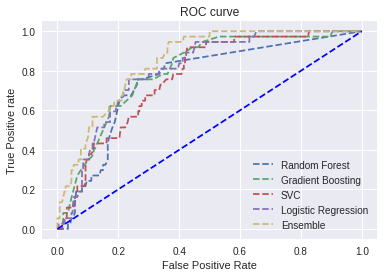

In [19]:
for i in names:
    y_pred = models[i].predict_proba(test_x)
    fpr1, tpr1, thresh1 = roc_curve(test_y, y_pred[:,1], pos_label=1)
    plt.plot(fpr1, tpr1, linestyle='--', label=i)

plt.plot([0,1],[0,1], linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()
    

In [20]:
pred_y = ensemble.predict_proba(test_x)
prob_y = [p[1] for p in pred_y]
print("ROC AUC score: ",roc_auc_score(test_y, prob_y))

pred_y = ensemble.predict(test_x)
print("Confusion matrix: \n", confusion_matrix(test_y, pred_y))
print("Accuracy :", accuracy_score(test_y, pred_y))


ROC AUC score:  0.8464656964656965
Confusion matrix: 
 [[258   2]
 [ 32   5]]
Accuracy : 0.8855218855218855
